In [ ]:
!pip install pandas scikit-learn


Sayısal olmayan sütunlar: Index(['feature_3'], dtype='object')
Model Performansı:
Ortalama Kare Hata (MSE): 0.10
Ortalama Mutlak Hata (MAE): 0.24
R² Skoru: -0.95


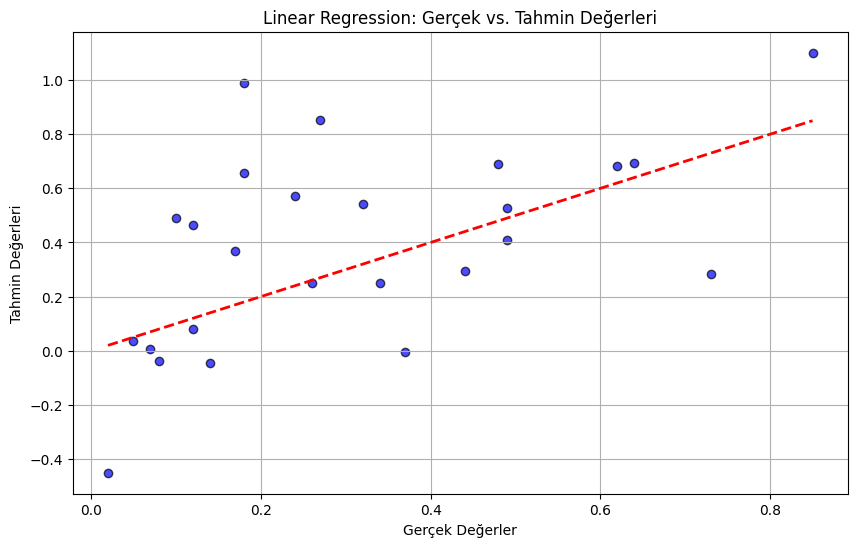

In [ ]:
# mea lı son regresyon versiyonu
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# ZIP dosyasını açma
zip_path = '/communities+and+crime.zip'
extract_path = '/communities_crime_data'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Veri yükleme
data_path = f"{extract_path}/communities.data"
columns = [f"feature_{i}" for i in range(128)]
columns[-1] = 'target'
data = pd.read_csv(data_path, header=None, names=columns, na_values='?')

# Eksik değerleri temizleme
data = data.dropna()

# Sayısal olmayan sütunları belirleme ve kaldırma
non_numeric_columns = data.select_dtypes(include=['object']).columns
print("Sayısal olmayan sütunlar:", non_numeric_columns)

# 'feature_0' gibi metin sütunlarını kaldırıyoruz
data = data.drop(columns=non_numeric_columns)

# Hedef ve öngörücü değişkenleri ayırma
X = data.drop(columns=['target'])  # 'target' bağımlı değişken
y = data['target']

# Eğitim ve test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model oluşturma ve eğitme
model = LinearRegression()
model.fit(X_train, y_train)

# Tahmin ve performans değerlendirme
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Sonuçları yazdırma
print("Model Performansı:")
print(f"Ortalama Kare Hata (MSE): {mse:.2f}")
print(f"Ortalama Mutlak Hata (MAE): {mae:.2f}")
print(f"R² Skoru: {r2:.2f}")

# Tahmin ve gerçek değerleri görselleştirme
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)
plt.title('Linear Regression: Gerçek vs. Tahmin Değerleri')
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Değerleri')
plt.grid(True)
plt.show()


In [ ]:
#decision tree ile yapılan tam recomandation düşük doğruluklu
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
import graphviz

# ZIP dosyasını aç
zip_path = '/content/archive (1).zip'
extract_path = '/content/extracted_archive1'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Dosya yollarını belirle
training_data_path = os.path.join(extract_path, 'Training.csv')
symptom_severity_path = os.path.join(extract_path, 'Symptom-severity.csv')
diet_recommendation_path = os.path.join(extract_path, 'diets.csv')
workout_recommendation_path = os.path.join(extract_path, 'workout_df.csv')

# Veri setlerini yükle
training_data = pd.read_csv(training_data_path)
symptom_severity = pd.read_csv(symptom_severity_path)
diet_recommendations = pd.read_csv(diet_recommendation_path)
workout_recommendations = pd.read_csv(workout_recommendation_path)

# Kolon isimlerini kontrol et ve eşleştir
print("Diet Recommendations Columns:", diet_recommendations.columns)
print("Workout Recommendations Columns:", workout_recommendations.columns)

# Rename columns to ensure consistency
if 'Disease' in diet_recommendations.columns:
    diet_recommendations.rename(columns={'Disease': 'Predicted Disease'}, inplace=True)
if 'disease' in workout_recommendations.columns:
    workout_recommendations.rename(columns={'disease': 'Predicted Disease'}, inplace=True)

# Veri türlerini eşitle
results_df = pd.DataFrame()
diet_recommendations['Predicted Disease'] = diet_recommendations['Predicted Disease'].astype(str)
workout_recommendations['Predicted Disease'] = workout_recommendations['Predicted Disease'].astype(str)

# Eğitim verilerini incele
print(training_data.head())
print(training_data.info())

# Özellikler (X) ve hedef değişken (y)
X = training_data.iloc[:, :-1]  # Belirtiler
y = training_data['prognosis']  # Hastalık

# Veri dengesizliğini çözmek için SMOTE uygulayın
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modeli oluştur ve eğit
model = DecisionTreeClassifier(max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

# Test seti ile tahmin yap
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# 1. Tahmin Sonuçlarını Excel'e Kaydet
results_df = X_test.copy()
results_df['Actual Disease'] = y_test.values
results_df['Predicted Disease'] = y_pred.astype(str)

# Beslenme ve egzersiz önerilerini ekle
results_df = results_df.merge(diet_recommendations, on='Predicted Disease', how='left')
results_df = results_df.merge(workout_recommendations, on='Predicted Disease', how='left')

output_path = '/mnt/data/decision_tree_results_with_recommendations.xlsx'
results_df.to_excel(output_path, index=False)
print(f"Tahmin sonuçları ve öneriler başarıyla {output_path} dosyasına kaydedildi.")

# 2. Karar Ağacını Metin Formatında Kaydet
tree_rules = export_text(model, feature_names=list(X.columns))
text_path = '/mnt/data/decision_tree_rules.txt'
with open(text_path, 'w') as file:
    file.write(tree_rules)
print(f"Karar ağacı kuralları başarıyla {text_path} dosyasına kaydedildi.")

# 3. Karar Ağacını Görselleştirerek Kaydet
dot_data = export_graphviz(
    model,
    out_file=None,
    feature_names=X.columns,
    class_names=model.classes_,
    filled=True,
    rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph_path = '/mnt/data/decision_tree_graph'
graph.render(graph_path)
print(f"Karar ağacı görselleştirmesi {graph_path}.pdf olarak kaydedildi.")

# 4. Özellik Önemlerini Excel'e Kaydet
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
importance_path = '/mnt/data/feature_importances.xlsx'
feature_importances.to_excel(importance_path, index=False)
print(f"Özellik önemleri başarıyla {importance_path} dosyasına kaydedildi.")

# Örnek bir belirtiler listesiyle tahmin yap
example_symptoms = X_test.iloc[10:11]  # Örnek bir satır DataFrame formatında seçiliyor
predicted_disease = model.predict(example_symptoms)[0]

predicted_diet = diet_recommendations[diet_recommendations['Predicted Disease'] == predicted_disease]
predicted_workout = workout_recommendations[workout_recommendations['Predicted Disease'] == predicted_disease]

diet_recommendation = predicted_diet['Diet'].values[0] if not predicted_diet.empty else "No recommendation"
workout_recommendation = predicted_workout['workout'].values[0] if not predicted_workout.empty else "No recommendation"

print(f"Predicted Disease: {predicted_disease}")
print(f"Diet Recommendation: {diet_recommendation}")
print(f"Workout Recommendation: {workout_recommendation}")


Diet Recommendations Columns: Index(['Disease', 'Diet'], dtype='object')
Workout Recommendations Columns: Index(['Unnamed: 0.1', 'Unnamed: 0', 'disease', 'workout'], dtype='object')
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0               

In [ ]:
# random forest ile yapılan recomendation yüksek doğruluklu
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# ZIP dosyasını aç
zip_path = '/content/archive (1).zip'
extract_path = '/content/extracted_archive1'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Dosya yollarını belirle
training_data_path = os.path.join(extract_path, 'Training.csv')
symptom_severity_path = os.path.join(extract_path, 'Symptom-severity.csv')
diet_recommendation_path = os.path.join(extract_path, 'diets.csv')
workout_recommendation_path = os.path.join(extract_path, 'workout_df.csv')

# Veri setlerini yükle
training_data = pd.read_csv(training_data_path)
symptom_severity = pd.read_csv(symptom_severity_path)
diet_recommendations = pd.read_csv(diet_recommendation_path)
workout_recommendations = pd.read_csv(workout_recommendation_path)

# Kolon isimlerini kontrol et ve eşleştir
print("Diet Recommendations Columns:", diet_recommendations.columns)
print("Workout Recommendations Columns:", workout_recommendations.columns)

# Rename columns to ensure consistency
if 'Disease' in diet_recommendations.columns:
    diet_recommendations.rename(columns={'Disease': 'Predicted Disease'}, inplace=True)
if 'disease' in workout_recommendations.columns:
    workout_recommendations.rename(columns={'disease': 'Predicted Disease'}, inplace=True)

# Veri türlerini eşitle
results_df = pd.DataFrame()
diet_recommendations['Predicted Disease'] = diet_recommendations['Predicted Disease'].astype(str)
workout_recommendations['Predicted Disease'] = workout_recommendations['Predicted Disease'].astype(str)

# Eğitim verilerini incele
print(training_data.head())
print(training_data.info())

# Özellikler (X) ve hedef değişken (y)
X = training_data.iloc[:, :-1]  # Belirtiler
y = training_data['prognosis']  # Hastalık

# Veri dengesizliğini çözmek için SMOTE uygulayın
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Random Forest modelini oluştur ve eğit
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Test seti ile tahmin yap
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

# 1. Tahmin Sonuçlarını Excel'e Kaydet
results_df = X_test.copy()
results_df['Actual Disease'] = y_test.values
results_df['Predicted Disease'] = y_pred.astype(str)

# Beslenme ve egzersiz önerilerini ekle
results_df = results_df.merge(diet_recommendations, on='Predicted Disease', how='left')
results_df = results_df.merge(workout_recommendations, on='Predicted Disease', how='left')

output_path = '/mnt/data/decision_tree_results_with_recommendations.xlsx'
results_df.to_excel(output_path, index=False)
print(f"Tahmin sonuçları ve öneriler başarıyla {output_path} dosyasına kaydedildi.")

# 2. Özellik Önemlerini Excel'e Kaydet
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
importance_path = '/mnt/data/feature_importances.xlsx'
feature_importances.to_excel(importance_path, index=False)
print(f"Özellik önemleri başarıyla {importance_path} dosyasına kaydedildi.")

# Örnek bir belirtiler listesiyle tahmin yap
example_symptoms = X_test.iloc[10:11]  # Örnek bir satır DataFrame formatında seçiliyor
predicted_disease = model.predict(example_symptoms)[0]

predicted_diet = diet_recommendations[diet_recommendations['Predicted Disease'] == predicted_disease]
predicted_workout = workout_recommendations[workout_recommendations['Predicted Disease'] == predicted_disease]

diet_recommendation = predicted_diet['Diet'].values[0] if not predicted_diet.empty else "No recommendation"
workout_recommendation = predicted_workout['workout'].values[0] if not predicted_workout.empty else "No recommendation"

print(f"Predicted Disease: {predicted_disease}")
print(f"Diet Recommendation: {diet_recommendation}")
print(f"Workout Recommendation: {workout_recommendation}")


Diet Recommendations Columns: Index(['Disease', 'Diet'], dtype='object')
Workout Recommendations Columns: Index(['Unnamed: 0.1', 'Unnamed: 0', 'disease', 'workout'], dtype='object')
   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0               

                              Drug Reaction            Allergist
0                                   Allergy            Allergist
1                             Hypertension          Cardiologist
2                              Heart attack         Cardiologist
3                                 Psoriasis        Dermatologist
4                               Chicken pox        Dermatologist
5                                      Acne        Dermatologist
6                                  Impetigo        Dermatologist
7                          Fungal infection        Dermatologist
8                            Hypothyroidism      Endocrinologist
9                                 Diabetes       Endocrinologist
10                             Hypoglycemia      Endocrinologist
11                          Hyperthyroidism      Endocrinologist
12                                     GERD   Gastroenterologist
13                      Peptic ulcer diseae   Gastroenterologist
14                       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

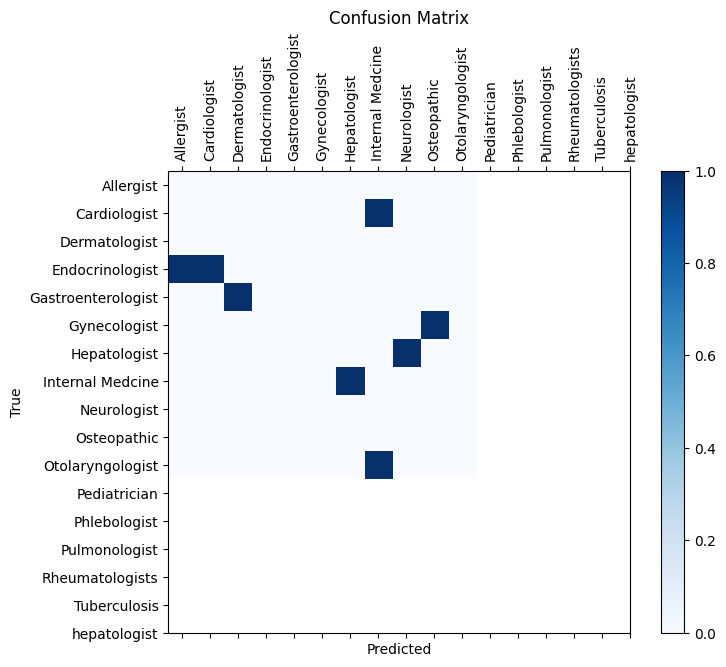

Class: Allergist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.88

Class: Cardiologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.86

Class: Dermatologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.88

Class: Endocrinologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 1.00

Class: Gastroenterologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 1.00

Class: Gynecologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 1.00

Class: Hepatologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.86

Class: Internal Medcine
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.71

Class: Neurologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.88

Class: Osteopathic
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 0.88

Class: Otolaryngologist
Sensitivity (Duyarlılık): 0.00
Specificity (Özgüllük): 1.00



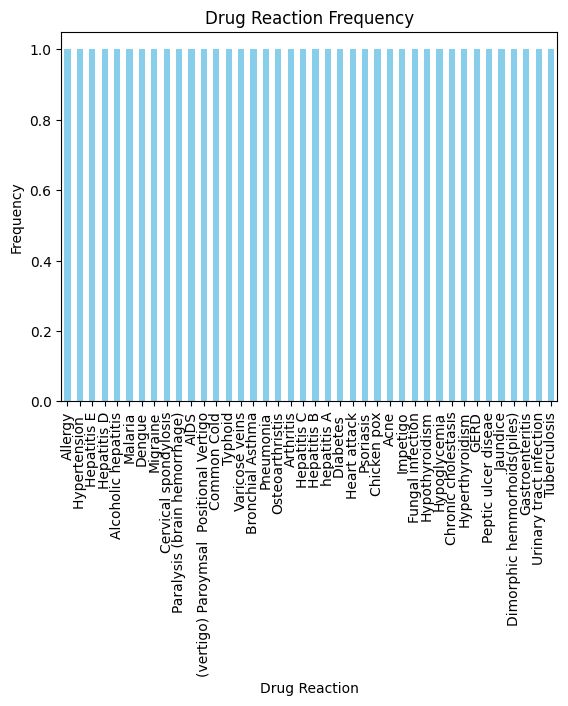

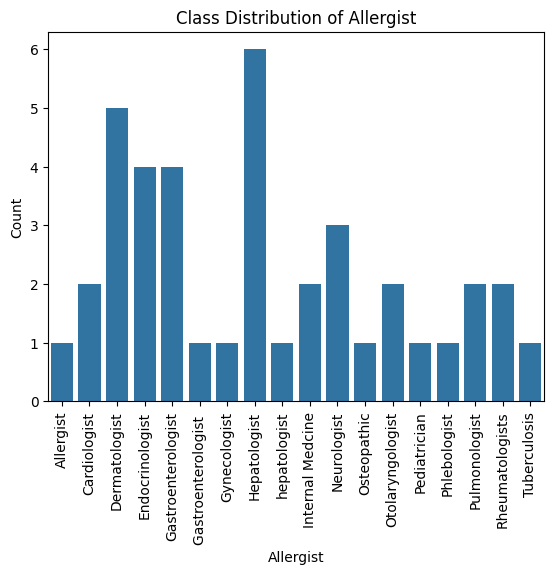

In [ ]:
#son clasification kodu olarak bunu kullandık
# Gerekli kütüphaneleri yükleyin
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns

# ZIP dosyasını açın
zip_path = '/content/archive.zip'
extract_path = '/content/extracted_archive'
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Veri seti yolunu belirleyin
doctor_vs_disease_path = os.path.join(extract_path, 'Doctor_Versus_Disease.csv')

# Veri setini doğru encoding ile yükleyin
df = pd.read_csv(doctor_vs_disease_path, encoding='ISO-8859-1')  # Encoding'i ISO-8859-1 olarak değiştirdik

# Pandas ayarlarıyla tüm satırları ve sütunları görüntüle
pd.set_option('display.max_rows', None)  # Tüm satırları göster
pd.set_option('display.max_columns', None)  # Tüm sütunları göster

# Verinin tamamını görüntüle
print(df)

# Veri hakkında temel bilgiler
print("\nVeri hakkında temel bilgiler:")
print(df.info())

# Sayısal sütunlar için istatistiksel özet
print("\nSayısal sütunlar için istatistiksel özet:")
print(df.describe())

# Kategorik veriler için frekans bilgisi
print("\nKategorik 'Drug Reaction' verisinin frekansları:")
print(df['Drug Reaction'].value_counts())

# Özellikler (X) ve hedef değişkeni (y) seçin
X = df['Drug Reaction']  # 'Disease' yerine doğru olan 'Drug Reaction' kolonunu kullanalım
y = df['Allergist']  # Uzmanlık alanı (Allergist)

# Özellikleri sayısallaştırmak için Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X_encoded = le.fit_transform(X)

# Veriyi eğitim ve test setlerine ayırın
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_encoded.reshape(-1, 1), y, test_size=0.2, random_state=42)

# Modeli oluşturun
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Tahminler yapın
y_pred = model.predict(X_test)

# Model performansını değerlendirin
from sklearn.metrics import classification_report, confusion_matrix
print("\nModel Performansı:")
print(classification_report(y_test, y_pred))

# Confusion Matrix hesaplama
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Grafikle Confusion Matrix'i gösterme
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(cm, cmap='Blues')
fig.colorbar(cax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(range(len(model.classes_)), model.classes_, rotation=90)
plt.yticks(range(len(model.classes_)), model.classes_)
plt.show()

# Her sınıf için Sensitivity (Duyarlılık) ve Specificity (Özgüllük) hesaplama
class_names = model.classes_

for i, class_name in enumerate(class_names):
    # Confusion matrix satır ve sütunları
    if i < cm.shape[0]:  # Sadece mevcut satır ve sütunlar üzerinde işlem yapalım
        tp = cm[i, i]  # Doğru Pozitif (True Positive)
        fp = cm[:, i].sum() - tp  # Yanlış Pozitif (False Positive)
        fn = cm[i, :].sum() - tp  # Yanlış Negatif (False Negative)
        tn = cm.sum() - (tp + fp + fn)  # Doğru Negatif (True Negative)

        # Sensitivity (Duyarlılık) ve Specificity (Özgüllük) hesaplama
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0  # Duyarlılık
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Özgüllük

        # Sonuçları yazdırma
        print(f"Class: {class_name}")
        print(f"Sensitivity (Duyarlılık): {sensitivity:.2f}")
        print(f"Specificity (Özgüllük): {specificity:.2f}")
        print()

# Veriyi görselleştirme
# Özelliklerin dağılımını görmek için histogram
df['Drug Reaction'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Drug Reaction Frequency')
plt.xlabel('Drug Reaction')
plt.ylabel('Frequency')
plt.show()

# Hedef değişkenin sınıf dağılımını görmek için
# Hedef değişkenin sınıf dağılımını görmek için
sns.countplot(data=df, x='Allergist')
plt.title('Class Distribution of Allergist')
plt.xlabel('Allergist')
plt.ylabel('Count')

# x-ekseni etiketlerini dikey yapma
plt.xticks(rotation=90)

plt.show()
